# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv',sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv',sep=';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

print('Number of rows AZDIAS: {}'.format(len(azdias)))
print('Number of rows Summary: {}'.format(len(feat_info)))

Number of rows AZDIAS: 891221
Number of rows Summary: 85


In [4]:
feat_info.head(10)

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


In [5]:
azdias.head(5)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [6]:
# Identify missing or unknown data values and convert them to NaNs.

feat_info.missing_or_unknown = feat_info.missing_or_unknown.str.strip('[]').str.split(',')



In [7]:
#create a dictionary with the data in the feat_info df

na_dict=dict(zip(feat_info.attribute,feat_info.missing_or_unknown))

In [8]:
na_dict

{'AGER_TYP': ['-1', '0'],
 'ALTERSKATEGORIE_GROB': ['-1', '0', '9'],
 'ANREDE_KZ': ['-1', '0'],
 'CJT_GESAMTTYP': ['0'],
 'FINANZ_MINIMALIST': ['-1'],
 'FINANZ_SPARER': ['-1'],
 'FINANZ_VORSORGER': ['-1'],
 'FINANZ_ANLEGER': ['-1'],
 'FINANZ_UNAUFFAELLIGER': ['-1'],
 'FINANZ_HAUSBAUER': ['-1'],
 'FINANZTYP': ['-1'],
 'GEBURTSJAHR': ['0'],
 'GFK_URLAUBERTYP': [''],
 'GREEN_AVANTGARDE': [''],
 'HEALTH_TYP': ['-1', '0'],
 'LP_LEBENSPHASE_FEIN': ['0'],
 'LP_LEBENSPHASE_GROB': ['0'],
 'LP_FAMILIE_FEIN': ['0'],
 'LP_FAMILIE_GROB': ['0'],
 'LP_STATUS_FEIN': ['0'],
 'LP_STATUS_GROB': ['0'],
 'NATIONALITAET_KZ': ['-1', '0'],
 'PRAEGENDE_JUGENDJAHRE': ['-1', '0'],
 'RETOURTYP_BK_S': ['0'],
 'SEMIO_SOZ': ['-1', '9'],
 'SEMIO_FAM': ['-1', '9'],
 'SEMIO_REL': ['-1', '9'],
 'SEMIO_MAT': ['-1', '9'],
 'SEMIO_VERT': ['-1', '9'],
 'SEMIO_LUST': ['-1', '9'],
 'SEMIO_ERL': ['-1', '9'],
 'SEMIO_KULT': ['-1', '9'],
 'SEMIO_RAT': ['-1', '9'],
 'SEMIO_KRIT': ['-1', '9'],
 'SEMIO_DOM': ['-1', '9'],
 'SEMIO_KA

In [9]:
def convert_keys_to_nan(df, keys_dict):
    for attribute in keys_dict:
        if len(keys_dict[attribute])>0 and keys_dict[attribute] != ['']:
            try:
                # Check if attribute is in dataframe
                if attribute in df.columns:       
                    keys_array = keys_dict[attribute]
                    for key in keys_array:
                        if key == 'X' or key == 'XX':
                            key = str(key)
                        else:
                            key = int(key)
                        df[attribute].replace(key, np.nan, inplace=True)
            except Exception as e:
                print('Exception in column: {}'.format(keys_dict[attribute])) 

In [10]:
convert_keys_to_nan(azdias, na_dict)

In [11]:
azdias

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,3.0,1.0,2,2.0,3,1,5,2,2,5,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
6,NaN,2.0,2,5.0,1,5,1,5,4,3,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0
7,NaN,1.0,1,3.0,3,3,4,1,3,2,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,2.0,5.0,2.0
8,NaN,3.0,1,3.0,4,4,2,4,2,2,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,4.0,3.0
9,NaN,3.0,2,4.0,2,4,2,3,5,4,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,3.0,1.0


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [12]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

azdias_num_nas=azdias.isna().sum()
azdias_num_nas_perc=azdias.isna().sum()/len(azdias)


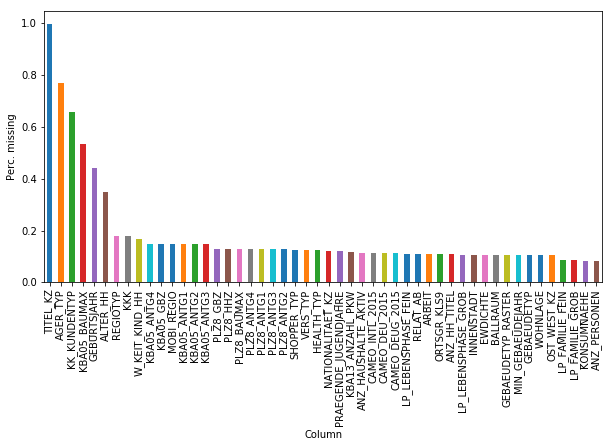

In [13]:
# Investigate patterns in the amount of missing data in each column.
plt.figure(figsize=(10,5))
plt.xlabel('Column')
plt.ylabel('Perc. missing')
azdias_num_nas_perc.sort_values(ascending=False).head(50).plot(kind='bar')

**Analysis**: Six columns seem to have more than 20% missing values. The rest have at least 80% of the observations

(array([ 32.,   7.,  37.,   3.,   0.,   0.,   1.,   0.,   1.,   0.,   1.,
          0.,   0.,   1.,   0.,   1.,   0.,   0.,   0.]),
 array([ 0.  ,  0.05,  0.1 ,  0.15,  0.2 ,  0.25,  0.3 ,  0.35,  0.4 ,
         0.45,  0.5 ,  0.55,  0.6 ,  0.65,  0.7 ,  0.75,  0.8 ,  0.85,
         0.9 ,  0.95]),
 <a list of 19 Patch objects>)

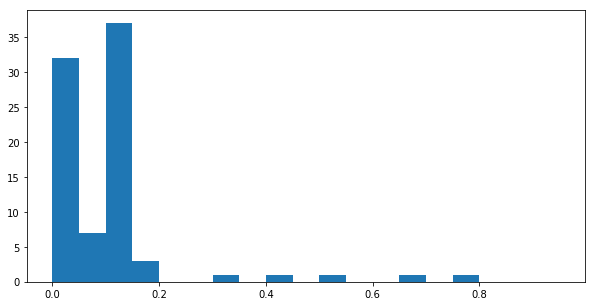

In [14]:
plt.figure(figsize=(10,5))
plt.hist(azdias_num_nas_perc,bins=np.arange(0,1,0.05))

**Analysis**: As mentioned before, most columns have at most 35% missing values. There are a few outliers with 40 to 80% NA's.

In [15]:
print('Average perc. of missing values: {}%'.format(round(azdias_num_nas_perc.mean()*100),1))

Average perc. of missing values: 11.0%


In [16]:
print('Median perc. of missing values: {}%'.format(round(azdias_num_nas_perc.median()*100),1))

Median perc. of missing values: 10.0%


In [17]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

drop_cols=azdias_num_nas_perc[azdias_num_nas_perc>0.35]

In [18]:
azdias.drop(columns=drop_cols.index,inplace=True)

#### Discussion 1.1.2: Assess Missing Data in Each Column

As shown before, most columns (79 of 85) have at least 80% of observations, and, in average, each columns has only 11% of NA's. However, six columns of the dataset had more than 20% in missing values. One of them ('TITEL_KZ') was almost completely empty, and others like 'AGER_TYP' and 'KK_KUNDENTYP' had more than 60% missing observations.

The removed columns and their corresponding % of missing values were: 



In [19]:
print(drop_cols)

AGER_TYP        0.769554
GEBURTSJAHR     0.440203
TITEL_KZ        0.997576
KK_KUNDENTYP    0.655967
KBA05_BAUMAX    0.534687
dtype: float64


#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [20]:
# How much data is missing in each row of the dataset?

azdias_na_rows=azdias.isnull().sum(axis=1)
azdias_na_rows_perc=azdias_na_rows/len(azdias.columns)

(array([  4.53093000e+05,   1.76957000e+05,   3.06400000e+04,
          1.81020000e+04,   1.65110000e+04,   1.73830000e+04,
          1.71390000e+04,   1.01280000e+04,   2.00870000e+04,
          1.33940000e+04,   4.91100000e+03,   2.42500000e+03,
          9.96000000e+02,   2.87600000e+03,   2.17600000e+03,
          4.39500000e+03,   2.74000000e+03,   1.25700000e+03,
          5.25000000e+02,   1.04300000e+03,   4.75000000e+02,
          2.48000000e+02,   1.34000000e+02,   1.26000000e+02,
          1.18000000e+02,   6.10000000e+01,   5.60000000e+01,
          2.80000000e+01,   2.30000000e+01,   9.00000000e+00,
          7.00000000e+00,   4.00000000e+00,   1.86000000e+02,
          2.51800000e+03,   8.47900000e+03,   4.54000000e+03,
          2.21100000e+03,   5.01000000e+02,   3.93000000e+02,
          1.97000000e+02,   7.80000000e+01,   1.13000000e+02,
          3.20000000e+02,   3.50000000e+01,   2.74040000e+04,
          1.09000000e+02,   4.89000000e+02,   0.00000000e+00,
        

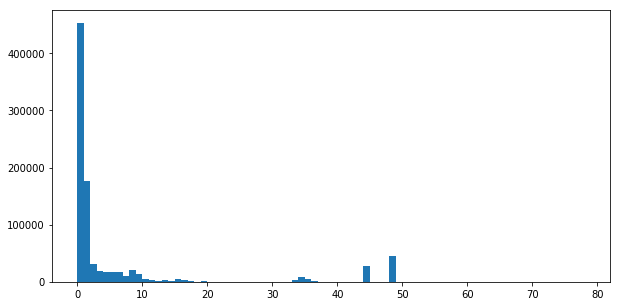

In [21]:
plt.figure(figsize=(10,5))

plt.hist(azdias_na_rows,bins=np.arange(0,79,1))


In [22]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
azdias_less10=azdias[azdias_na_rows<=10]
azdias_more10=azdias[azdias_na_rows>10]


In [23]:
len(azdias_less10)

778345

In [24]:
len(azdias_more10)

112876

In [25]:
#random 5 variables with low number nas
random5=azdias_num_nas_perc[azdias_num_nas_perc<0.1].sample(n=5,random_state=33)

In [26]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

def plot_vars(var_list):
    for var in var_list:
        fig,axes=plt.subplots(1,2,figsize=(12,5))

        fig.suptitle('Variable ' + var)

        sns.countplot(ax=axes[0], data=azdias_less10,x=var)
        axes[0].set_title('10 or less missing columns')

        sns.countplot(ax=axes[1], data=azdias_more10,x=var)
        axes[1].set_title('More than 10 missing columns')

        fig.show()


/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


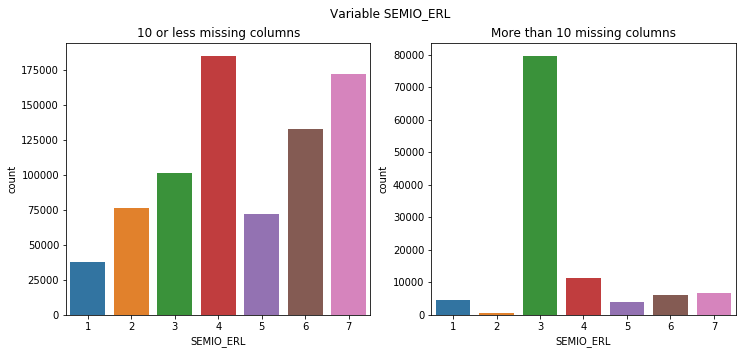

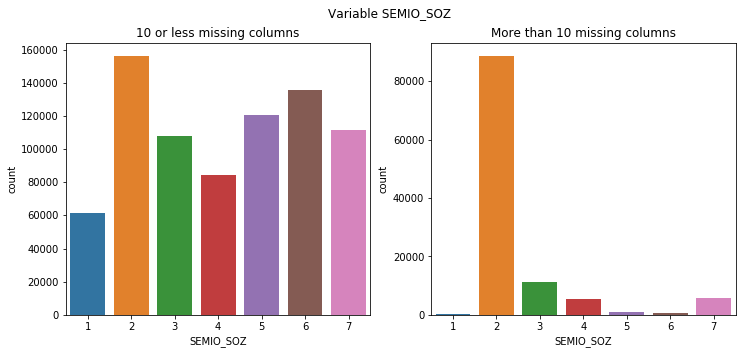

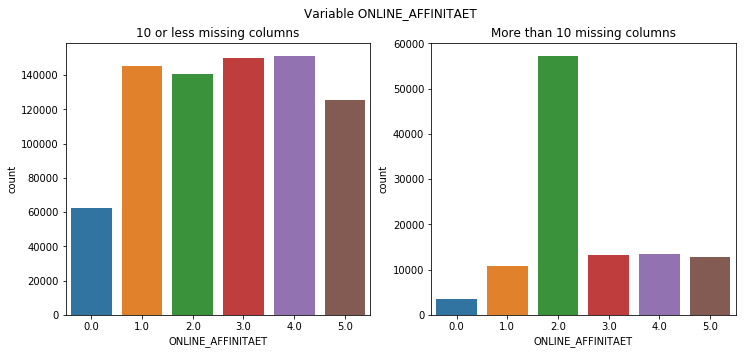

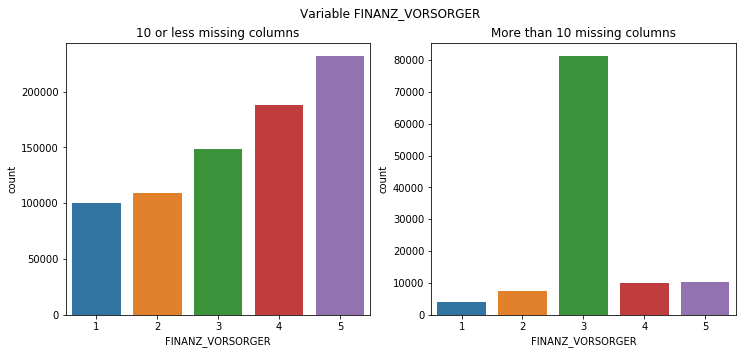

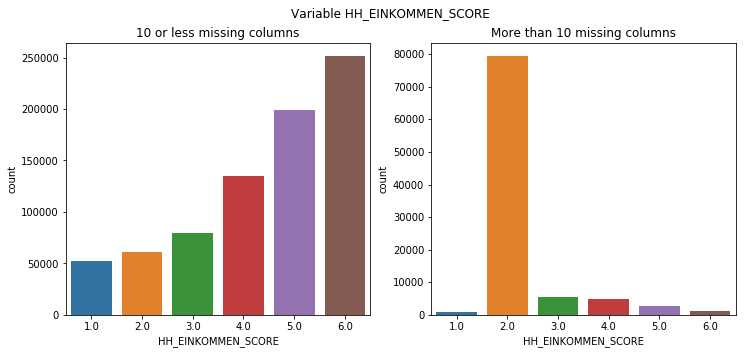

In [27]:
plot_vars(random5.index)

In [28]:
random5

SEMIO_ERL             0.000000
SEMIO_SOZ             0.000000
ONLINE_AFFINITAET     0.005446
FINANZ_VORSORGER      0.000000
HH_EINKOMMEN_SCORE    0.020587
dtype: float64

#### Discussion 1.1.3: Assess Missing Data in Each Row

As shown in the first histogram, most rows have less than 10 missing columns. For this reason, I used 10 as the threshold for the following analysis.

As can be seen in the comparison, both groups differ significatively. For example, when comparing the 'SEMIO_ERL' variable, it is evident that, while in the data with less missing columns the customers are rather uniformly distributed between the groups, in the data with more than 10 missing values the customers are mostly in the group 3. 

For this reason, removing those observations could be troublesome as we might be eliminating a specific group of customers that would be ignored in the clustering. 

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [29]:
# How many features are there of each data type?

feat_info['type'].value_counts()

ordinal        49
categorical    21
mixed           7
numeric         7
interval        1
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [30]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

cat_variables=feat_info.loc[feat_info['type']=='categorical','attribute']
cat_variables

0             AGER_TYP
2            ANREDE_KZ
3        CJT_GESAMTTYP
10           FINANZTYP
12     GFK_URLAUBERTYP
13    GREEN_AVANTGARDE
17     LP_FAMILIE_FEIN
18     LP_FAMILIE_GROB
19      LP_STATUS_FEIN
20      LP_STATUS_GROB
21    NATIONALITAET_KZ
38         SHOPPER_TYP
39             SOHO_KZ
40            TITEL_KZ
41            VERS_TYP
42            ZABEOTYP
47        KK_KUNDENTYP
52         GEBAEUDETYP
55         OST_WEST_KZ
57     CAMEO_DEUG_2015
58      CAMEO_DEU_2015
Name: attribute, dtype: object

In [31]:
cat_df=cat_variables[cat_variables.isin(azdias.columns)]

In [32]:
#binary and categorical with 3 or more
binary_vars=[]
cat3_vars=[]

for var in cat_df:
    unique=azdias[var].dropna().nunique()
    if unique ==2:
        binary_vars.append(var)
    else:
        cat3_vars.append(var)

In [33]:
binary_vars

['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ']

In [34]:
cat3_vars

['CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

In [35]:
# Re-encode categorical variable(s) to be kept in the analysis.

for var in binary_vars:
    print(azdias[var].value_counts())

2    465305
1    425916
Name: ANREDE_KZ, dtype: int64
0    715996
1    175225
Name: GREEN_AVANTGARDE, dtype: int64
0.0    810834
1.0      6888
Name: SOHO_KZ, dtype: int64
2.0    398722
1.0    381303
Name: VERS_TYP, dtype: int64
W    629528
O    168545
Name: OST_WEST_KZ, dtype: int64


In [36]:
#all binaries to 1 and 0
azdias['ANREDE_KZ'].replace([2,1],[1,0],inplace=True)
azdias['VERS_TYP'].replace([2.0,1.0],[1,0],inplace=True)
azdias['OST_WEST_KZ'].replace(['W','O'],[1,0],inplace=True)


In [37]:
#one-hot encoding for multicategory
azdias = pd.get_dummies(azdias, columns=cat3_vars)


In [38]:
azdias

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_7E,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E
0,2.0,0,3,4,3,5,5,3,0,NaN,...,0,0,0,0,0,0,0,0,0,0
1,1.0,1,1,5,2,5,4,5,0,3.0,...,0,1,0,0,0,0,0,0,0,0
2,3.0,1,1,4,1,2,3,5,1,3.0,...,0,0,0,0,0,0,0,0,0,0
3,4.0,1,4,2,5,2,1,2,0,2.0,...,0,0,0,0,0,0,0,0,0,0
4,3.0,0,4,3,4,1,3,2,0,3.0,...,0,0,0,0,0,0,0,0,0,0
5,1.0,1,3,1,5,2,2,5,0,3.0,...,0,0,0,1,0,0,0,0,0,0
6,2.0,1,1,5,1,5,4,3,0,2.0,...,0,0,0,0,0,0,0,0,0,0
7,1.0,0,3,3,4,1,3,2,0,1.0,...,0,0,0,0,0,0,0,0,0,0
8,3.0,0,4,4,2,4,2,2,1,3.0,...,0,0,0,0,0,0,0,0,0,0
9,3.0,1,2,4,2,3,5,4,1,2.0,...,0,0,0,0,0,0,0,0,0,0


#### Discussion 1.2.1: Re-Encode Categorical Features

In the previous cells we found that there are 5 binary and 13 variables with 3 or more categories. For the first ones, I standardized them to 0 and 1 values, and for the latter, I used one hot encoding to keep their information when doing the clustering.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [39]:
mixed_vars = feat_info.loc[feat_info.type == 'mixed','attribute']


In [40]:
mixed_vars

15      LP_LEBENSPHASE_FEIN
16      LP_LEBENSPHASE_GROB
22    PRAEGENDE_JUGENDJAHRE
56                 WOHNLAGE
59          CAMEO_INTL_2015
64             KBA05_BAUMAX
79              PLZ8_BAUMAX
Name: attribute, dtype: object

In [41]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

azdias['PRAEGENDE_JUGENDJAHRE'].value_counts()

14.0    188697
8.0     145988
5.0      86416
10.0     85808
3.0      55195
15.0     42547
11.0     35752
9.0      33570
6.0      25652
12.0     24446
1.0      21282
4.0      20451
2.0       7479
13.0      5764
7.0       4010
Name: PRAEGENDE_JUGENDJAHRE, dtype: int64

In [42]:
gen = {0: [1, 2], 
               1: [3, 4], 
               2: [5, 6, 7],
               3: [8, 9], 
               4: [10, 11, 12, 13],
               5:[14, 15]} 

def generation(value):
    try:
        for key, values in gen.items():
            if value in values:
                return key
    # In case value is NaN
    except ValueError:
        return np.nan

In [43]:
azdias['PRAEGENDE_JUGENDJAHRE_GEN'] = azdias['PRAEGENDE_JUGENDJAHRE'].apply(generation)


In [44]:
mainstream = [1, 3, 5, 8, 10, 12, 14]

def classify_movement(value):
    try:
        if value in mainstream:
            return 1
        else:
            return 0
    # In case value is NaN
    except ValueError:
        return np.nan

In [45]:
azdias['PRAEGENDE_JUGENDJAHRE_MOV'] = azdias['PRAEGENDE_JUGENDJAHRE'].apply(classify_movement)


In [46]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables
azdias['CAMEO_INTL_2015'].head(10)


0    NaN
1     51
2     24
3     12
4     43
5     54
6     22
7     14
8     13
9     15
Name: CAMEO_INTL_2015, dtype: object

In [47]:
azdias['CAMEO_INTL_2015'][1][0]

'5'

In [48]:
azdias['CAMEO_INTL_2015_WEALTH']=azdias['CAMEO_INTL_2015'].str[0].astype('float64')

In [49]:
azdias['CAMEO_INTL_2015_LIFESTAGE']=azdias['CAMEO_INTL_2015'].str[1].astype('float64')

In [50]:
other_mixed=mixed_vars[~(mixed_vars.isin(['PRAEGENDE_JUGENDJAHRE','CAMEO_INTL_2015'])) & (mixed_vars.isin(azdias.columns))]

In [51]:

azdias=pd.get_dummies(azdias,columns=other_mixed)
#drop variables
azdias=azdias.drop(['PRAEGENDE_JUGENDJAHRE','CAMEO_INTL_2015'],axis=1)

#### Discussion 1.2.2: Engineer Mixed-Type Features

There were 7 mixed type variables. 
* Using the data from the dictionary, I created the four new variables using the 'CAMEO_INTL_2015' and 'PRAEGENDE_JUGENDJAHRE' columns
    * For the CAMEO_INTL_2015 column I used the position of the characters in the string to create the new variables and converted them to a float type. As they are ordinal, I decided not to one hot encode them.
    * For the other one, I recoded the values by defining two functions
* A couple of the other mixed variables were removed in the na removing step.
* The rest of them, were one hot encoded to avoid losing their information.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [52]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)



In [93]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

azdias=azdias.drop(['ALTER_HH', 'GEBAEUDETYP_5.0'],axis=1)#these variables don't appear in the second dataset, and if not eliminated, cause a mismatch in the number of features when doing the last step

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [96]:
def clean_data(data):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    # Identify missing or unknown data values and convert them to NaNs.

    feat_info.missing_or_unknown = feat_info.missing_or_unknown.str.strip('[]').str.split(',')
    #create a dictionary with the data in the feat_info df

    na_dict=dict(zip(feat_info.attribute,feat_info.missing_or_unknown))
    #function to clean nas
    def convert_keys_to_nan(df, keys_dict):
        for attribute in keys_dict:
            if len(keys_dict[attribute])>0 and keys_dict[attribute] != ['']:
                try:
                    # Check if attribute is in dataframe
                    if attribute in df.columns:       
                        keys_array = keys_dict[attribute]
                        for key in keys_array:
                            if key == 'X' or key == 'XX':
                                key = str(key)
                            else:
                                key = int(key)
                            df[attribute].replace(key, np.nan, inplace=True)
                except Exception as e:
                    print('Exception in column: {}'.format(keys_dict[attribute])) # Put in code here to execute all main cleaning steps:
    convert_keys_to_nan(data, na_dict)
    
    #perc of nas by col
    df_num_nas_perc=data.isna().sum()/len(data)
    
    drop_cols=df_num_nas_perc[df_num_nas_perc>0.35]
    data.drop(columns=drop_cols.index,inplace=True)
    

    
    # select, re-encode, and engineer column values.
    cat_variables=feat_info.loc[feat_info['type']=='categorical','attribute']
    cat_df=cat_variables[cat_variables.isin(data.columns)]
    
    #binary and categorical with 3 or more
    binary_vars=[]
    cat3_vars=[]

    for var in cat_df:
        unique=data[var].dropna().nunique()
        if unique ==2:
            binary_vars.append(var)
        else:
            cat3_vars.append(var)
                
   
    data['VERS_TYP'].replace([2.0,1.0],[1,0],inplace=True)
    data['ANREDE_KZ'].replace([2,1],[1,0],inplace=True)

    data['OST_WEST_KZ'].replace(['W','O'],[1,0],inplace=True)

    data = pd.get_dummies(data, columns=cat3_vars)
    
    gen = {0: [1, 2], 
               1: [3, 4], 
               2: [5, 6, 7],
               3: [8, 9], 
               4: [10, 11, 12, 13],
               5:[14, 15]} 

    def generation(value):
        try:
            for key, values in gen.items():
                if value in values:
                    return key
        # In case value is NaN
        except ValueError:
            return np.nan
        
    data['PRAEGENDE_JUGENDJAHRE_GEN'] = data['PRAEGENDE_JUGENDJAHRE'].apply(generation)

    mainstream = [1, 3, 5, 8, 10, 12, 14]

    def classify_movement(value):
        try:
            if value in mainstream:
                return 1
            else:
                return 0
        # In case value is NaN
        except ValueError:
            return np.nan
        
    data['PRAEGENDE_JUGENDJAHRE_MOV'] = data['PRAEGENDE_JUGENDJAHRE'].apply(classify_movement)

    data['CAMEO_INTL_2015_WEALTH']=data['CAMEO_INTL_2015'].str[0].astype('float64')
    data['CAMEO_INTL_2015_LIFESTAGE']=data['CAMEO_INTL_2015'].str[1].astype('float64')
    
    other_mixed=mixed_vars[~(mixed_vars.isin(['PRAEGENDE_JUGENDJAHRE','CAMEO_INTL_2015'])) & (mixed_vars.isin(data.columns))]
    data=pd.get_dummies(data,columns=other_mixed)
    #drop variables
    data=data.drop(['PRAEGENDE_JUGENDJAHRE','CAMEO_INTL_2015'],axis=1)
    
    if 'ALTER_HH' in data.columns:
        data = data.drop(['ALTER_HH','GEBAEUDETYP_5.0'], axis=1)
    # Return the cleaned dataframe.
    return(data)

    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [100]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

rows_all=len(azdias)
azdias_clean=azdias.dropna(how='any')
rows_clean=len(azdias_clean)

In [101]:
print('Rows before cleaning: {}. Rows after cleaning:{}'.format(rows_all,rows_clean))

Rows before cleaning: 891221. Rows after cleaning:623211


In [102]:
#check that all variables are numerical
azdias_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 623211 entries, 1 to 891220
Columns: 256 entries, ALTERSKATEGORIE_GROB to PLZ8_BAUMAX_5.0
dtypes: float64(41), int64(23), uint8(192)
memory usage: 423.2 MB


In [103]:
# Apply feature scaling to the general population demographics data.

from sklearn.preprocessing import StandardScaler

instantiate_scaler=StandardScaler()

azdias_clean_standard=instantiate_scaler.fit_transform(azdias_clean)

### Discussion 2.1: Apply Feature Scaling

There is not much information about the specifics of each column. Moreover, there is a large number of variables, and therefore imputting values would be complex and time consuming. For this reason, I dropped all the rows that were not complete for the purpose of training the clustering model.

After that, I standardized all the features to values with mean=0 and sd=1 as instructed

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [104]:
# Apply PCA to the data.

from sklearn.decomposition import PCA
def do_pca(n_components, data):
    '''
    Transforms data using PCA to create n_components, and provides back the results of the
    transformation.
    
    INPUT: n_components - int - the number of principal components to create
           data - the data you would like to transform
           
    OUTPUT: pca - the pca object created after fitting the data
            X_pca - the transformed X matrix with new number of components
    '''
    pca = PCA(n_components)
    X_pca = pca.fit_transform(data)
    return pca, X_pca

In [105]:
azdias_clean.columns

Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'FINANZ_MINIMALIST',
       'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER',
       'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'GREEN_AVANTGARDE',
       'HEALTH_TYP',
       ...
       'WOHNLAGE_3.0', 'WOHNLAGE_4.0', 'WOHNLAGE_5.0', 'WOHNLAGE_7.0',
       'WOHNLAGE_8.0', 'PLZ8_BAUMAX_1.0', 'PLZ8_BAUMAX_2.0', 'PLZ8_BAUMAX_3.0',
       'PLZ8_BAUMAX_4.0', 'PLZ8_BAUMAX_5.0'],
      dtype='object', length=256)

In [106]:
256/2

128.0

In [107]:
pca_model,X_pca=do_pca(128,azdias_clean_standard)

In [108]:
pca_model.explained_variance_ratio_

array([ 0.07227629,  0.05087122,  0.02862324,  0.02575676,  0.02193265,
        0.01797483,  0.01740895,  0.01639889,  0.01601636,  0.01480627,
        0.01149858,  0.01087443,  0.01059683,  0.01035112,  0.00963644,
        0.00931229,  0.00902341,  0.00889531,  0.00872538,  0.00863084,
        0.008478  ,  0.00842412,  0.00836798,  0.00828927,  0.00819532,
        0.0079907 ,  0.00790045,  0.00772913,  0.00730347,  0.00708774,
        0.00687959,  0.00668665,  0.00628988,  0.006255  ,  0.00597342,
        0.00590217,  0.0058358 ,  0.00560422,  0.00556961,  0.00550933,
        0.00537887,  0.00529905,  0.00518716,  0.00515429,  0.00507714,
        0.00498635,  0.00493017,  0.00480699,  0.00473133,  0.00468426,
        0.00461414,  0.0045956 ,  0.00458321,  0.00452451,  0.0044715 ,
        0.00444853,  0.00442748,  0.00440468,  0.00437324,  0.00432583,
        0.00430971,  0.004306  ,  0.004273  ,  0.00426251,  0.00422449,
        0.0042116 ,  0.00418915,  0.00418424,  0.00417572,  0.00

In [109]:
# Investigate the variance accounted for by each principal component.

def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')
    

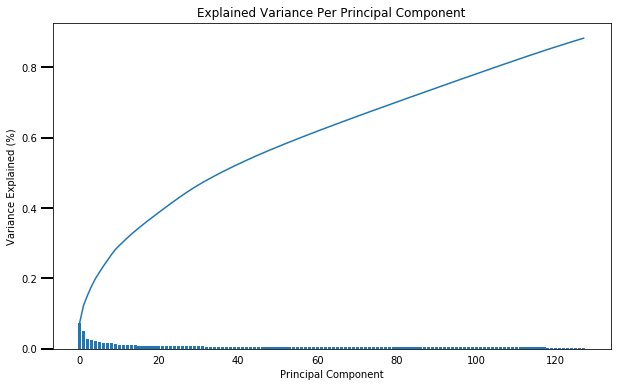

In [110]:
scree_plot(pca_model)

In [115]:
pca_model.explained_variance_ratio_[0:100].sum()

0.77810436467062483

In [116]:
# Re-apply PCA to the data while selecting for number of components to retain.

pca_model,X_pca=do_pca(100,azdias_clean_standard)

### Discussion 2.2: Perform Dimensionality Reduction

As shown above, by using the first 100 principal components, we are able to preserve approximately 78% of the variance in the data. This is a major dimensionality reduction considering that the initial number of variables was 256

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [117]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

pca_model.components_.shape


(100, 256)

In [118]:
def most_weighted_features(model,data,n_comp):
    for i in np.arange(1,n_comp+1,1):
        n_comp_1=i-1
        
        df=pd.DataFrame(model.components_[n_comp_1],index=data.columns,columns=['weight'])
        df=df.sort_values('weight',ascending=False)
        df_aux=pd.concat([df.head(5),df.tail(5)])
        plt.figure(figsize=(10,5))
        df_aux.plot(kind='bar')
        plt.title('Component {}'.format(i))

        print('Component {}:'.format(i))
        print(df_aux)

Component 1:
                          weight
LP_STATUS_GROB_1.0      0.181724
PLZ8_ANTG3              0.168896
HH_EINKOMMEN_SCORE      0.168893
CAMEO_INTL_2015_WEALTH  0.167939
PLZ8_ANTG4              0.163043
KBA05_GBZ              -0.169693
PLZ8_ANTG1             -0.170603
FINANZ_MINIMALIST      -0.175820
KBA05_ANTG1            -0.179582
MOBI_REGIO             -0.190570
Component 2:
                             weight
ALTERSKATEGORIE_GROB       0.210121
FINANZ_VORSORGER           0.204304
ZABEOTYP_3                 0.177129
SEMIO_ERL                  0.155889
RETOURTYP_BK_S             0.150117
FINANZ_ANLEGER            -0.191121
FINANZ_UNAUFFAELLIGER     -0.198055
ALTER_HH                  -0.207624
FINANZ_SPARER             -0.213615
PRAEGENDE_JUGENDJAHRE_GEN -0.226080
Component 3:
               weight
SEMIO_VERT   0.293573
SEMIO_FAM    0.249727
SEMIO_SOZ    0.243555
SEMIO_KULT   0.241377
FINANZTYP_5  0.134090
SEMIO_ERL   -0.207276
SEMIO_DOM   -0.245932
SEMIO_KRIT  -0.247355
SEMI

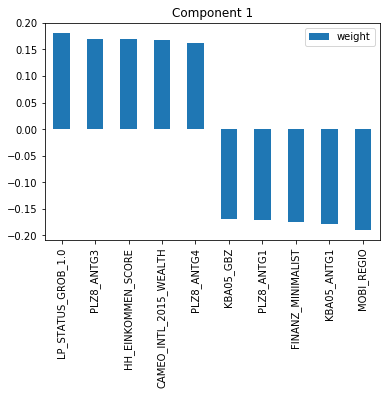

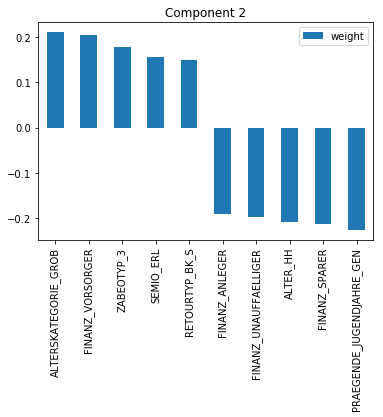

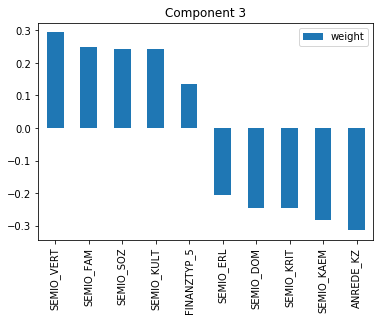

In [72]:
most_weighted_features(pca_model,azdias_clean,3)

### Discussion 2.3: Interpret Principal Components

In the first component, the most associated features were:
* Low (1) social status (positive)
* High share of 6-10 family houses (positive)
* Having a low income (positive)
* High share of 10+ family houses in the region(positive)
* Number of buildings in the microcell (negative)
* Low share of 1 family houses (negative)
* Low financial interest (negative)
* Having low movement patterns (negative)

Hence, this component is related to the type of place where the person lives (residential vs industrial), as well as their income and wealth.

In the second component, the most associated features were:
* Age (positive)
* Financial preparedness (positive)
* Energy provision - fair supplied (positive)
* Event orientedness (positive)
* Dutifulness (negative)
* Religiousness (negative - the affinity scale is inverted here, then positive)
* Return type (positive)
* Money saving (negative)
* Inconspicouous spending (negative)
* Generation (highest is younger, negative)

Hence, this component is related to the age (and the generation, that should be highly correlated), and mostly to personality features and financial interests. 
In the third component:

* Dreamfulness (positive)
* Family mindedness (positive)
* Socially mindedness (positive)
* Cultural minedness (positive)
* Financial investor type (positive)
* Event orientedness (negative)
* Dominant mindedness (negative)
* Critical mindedness (negative)
* Combative attitude (negative)
* Gender (1=female) (negative)

Hence, this component is related to the gender and personality features.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [121]:
small_data_rows=round(len(X_pca)*0.15)

np.random.shuffle(X_pca)

In [122]:
random_data=X_pca[0:small_data_rows]

In [123]:
random_data.shape

(93482, 100)

In [124]:
# Over a number of different cluster counts...
from sklearn.cluster import KMeans
sse=[]
for k in np.arange(10,31):
    kmeans = KMeans(k, random_state=33).fit(random_data)
    score = np.abs(kmeans.score(random_data))
    sse.append(score)
    print('Clusters: {}, SSE: {}'.format(k, score))

Clusters: 10, SSE: 14301928.053766828
Clusters: 11, SSE: 13859978.40424494
Clusters: 12, SSE: 13671467.898380129
Clusters: 13, SSE: 13499987.193345677
Clusters: 14, SSE: 13370008.82477848
Clusters: 15, SSE: 13162210.00070869
Clusters: 16, SSE: 13050515.16540896
Clusters: 17, SSE: 12828253.41340664
Clusters: 18, SSE: 12749165.325681021
Clusters: 19, SSE: 12419473.822972333
Clusters: 20, SSE: 12405961.443439627
Clusters: 21, SSE: 12215653.33579563
Clusters: 22, SSE: 12039769.37600011
Clusters: 23, SSE: 11974227.846227117
Clusters: 24, SSE: 11847472.089234214
Clusters: 25, SSE: 11828176.543646524
Clusters: 26, SSE: 11634178.463739317
Clusters: 27, SSE: 11614678.389426287
Clusters: 28, SSE: 11530349.708670061
Clusters: 29, SSE: 11292445.749259192
Clusters: 30, SSE: 11210161.149977606


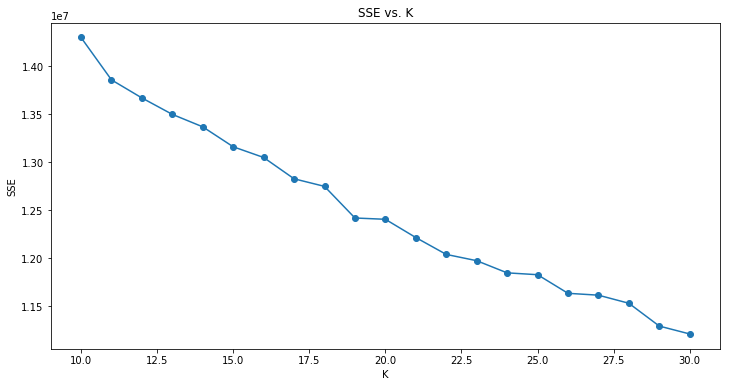

In [125]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

plt.figure(figsize=(12, 6))

plt.xlabel('K')
plt.ylabel('SSE')
plt.title('SSE vs. K')
plt.plot(np.arange(10,31), sse, linestyle='-', marker='o');


In [126]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

kmeans = KMeans(25, random_state=33).fit(X_pca)

In [135]:
azdias_clusters=kmeans.predict(X_pca)

### Discussion 3.1: Apply Clustering to General Population

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [127]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

#Preprocessing
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv',sep=';')
customers= pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')




In [128]:
customers=clean_data(customers)

In [129]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191652 entries, 0 to 191651
Columns: 256 entries, ALTERSKATEGORIE_GROB to PLZ8_BAUMAX_5.0
dtypes: float64(41), int64(23), uint8(192)
memory usage: 128.7 MB


In [130]:
customers.isna().sum()/len(customers)

ALTERSKATEGORIE_GROB        0.001252
ANREDE_KZ                   0.000000
FINANZ_MINIMALIST           0.000000
FINANZ_SPARER               0.000000
FINANZ_VORSORGER            0.000000
FINANZ_ANLEGER              0.000000
FINANZ_UNAUFFAELLIGER       0.000000
FINANZ_HAUSBAUER            0.000000
GREEN_AVANTGARDE            0.000000
HEALTH_TYP                  0.255620
RETOURTYP_BK_S              0.016765
SEMIO_SOZ                   0.000000
SEMIO_FAM                   0.000000
SEMIO_REL                   0.000000
SEMIO_MAT                   0.000000
SEMIO_VERT                  0.000000
SEMIO_LUST                  0.000000
SEMIO_ERL                   0.000000
SEMIO_KULT                  0.000000
SEMIO_RAT                   0.000000
SEMIO_KRIT                  0.000000
SEMIO_DOM                   0.000000
SEMIO_KAEM                  0.000000
SEMIO_PFLICHT               0.000000
SEMIO_TRADV                 0.000000
SOHO_KZ                     0.243128
VERS_TYP                    0.255620
A

In [131]:
#Feature transformation

customers_clean = customers.dropna()


In [132]:
azdias.shape

(891221, 256)

In [133]:
set(azdias.columns).difference(customers.columns)#set must be empty

set()

In [134]:

customers_clean_standard=instantiate_scaler.transform(customers_clean)

In [139]:
customers_pca = pca_model.transform(customers_clean_standard)


In [140]:
customer_clusters=kmeans.predict(customers_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [151]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

cust_values=pd.Series(customer_clusters,name='customer').value_counts()
pop_values=pd.Series(azdias_clusters,name='demographics').value_counts()

In [152]:
cust_perc=cust_values/cust_values.sum()
pop_perc=pop_values/pop_values.sum()

In [155]:
all_perc=pd.concat([cust_perc,pop_perc],axis=1)


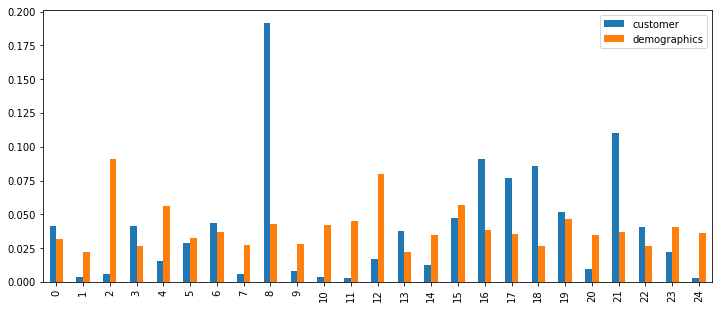

In [171]:
all_perc.plot(kind='bar',figsize=(12,5))

In [187]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

cluster8=kmeans.cluster_centers_[8]
pd.Series(cluster8).sort_values(ascending=False).head(10)

3     3.847751
2     1.844646
4     0.904846
23    0.881745
1     0.714834
34    0.682339
99    0.621778
73    0.544664
77    0.483578
85    0.471530
dtype: float64

In [183]:
def most_weighted_features1(model,data,component):
    
    df=pd.DataFrame(model.components_[component],index=data.columns,columns=['weight'])
    df=df.sort_values('weight',ascending=False)
    df_aux=pd.concat([df.head(5),df.tail(5)])
    plt.figure(figsize=(10,5))
    df_aux.plot(kind='bar')
    plt.title('Component {}'.format(component))

    print('Component {}:'.format(component))
    print(df_aux)

Component 3:
                             weight
ANZ_PERSONEN               0.210945
LP_FAMILIE_GROB_5.0        0.192636
GREEN_AVANTGARDE           0.163982
SEMIO_KAEM                 0.154513
LP_STATUS_GROB_5.0         0.147327
LP_STATUS_GROB_4.0        -0.148261
PRAEGENDE_JUGENDJAHRE_MOV -0.163982
W_KEIT_KIND_HH            -0.167326
LP_FAMILIE_FEIN_1.0       -0.252006
LP_FAMILIE_GROB_1.0       -0.252006


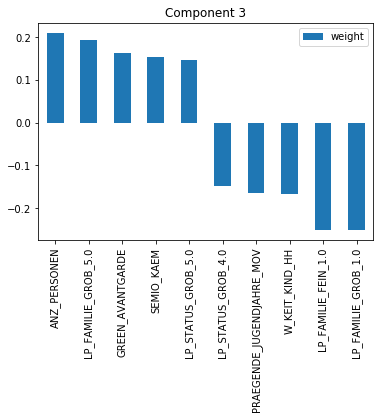

In [185]:
most_weighted_features1(pca_model,customers_clean,3)

In [188]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

cluster2=kmeans.cluster_centers_[2]
pd.Series(cluster2).sort_values(ascending=False).head(10)

0     6.576133
4     1.331010
12    0.897200
56    0.316933
42    0.267839
25    0.253507
33    0.244985
60    0.215275
57    0.210599
51    0.198297
dtype: float64

Component 0:
                          weight
LP_STATUS_GROB_1.0      0.181407
HH_EINKOMMEN_SCORE      0.167506
PLZ8_ANTG3              0.167435
CAMEO_INTL_2015_WEALTH  0.166468
PLZ8_ANTG4              0.161847
KBA05_GBZ              -0.167341
PLZ8_ANTG1             -0.169250
FINANZ_MINIMALIST      -0.177694
KBA05_ANTG1            -0.177889
MOBI_REGIO             -0.188748


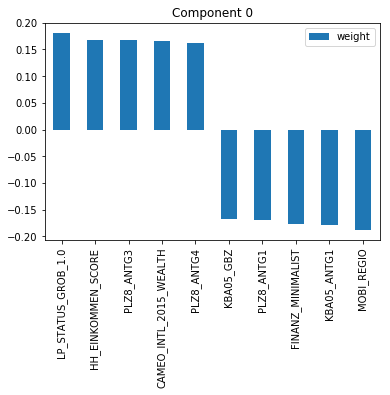

In [189]:
most_weighted_features1(pca_model,customers_clean,0)

### Discussion 3.3: Compare Customer Data to Demographics Data

As shown in the first graph, there are numerous clusters in which there is a large difference between the customers and whole demographics datasets. 

In particular,  customers are over represented  in the 0,8,16,17,18 and 21 clusters, while they are under represented in the rest. 

**Over represented features**

The cluster where the customers are most overrepresented is the 8, as it seems that the concentration is almost 5x than in the demographics dataset. According to the cluster centroid, the strongest principal component in that cluster is the PC 3. The features of that PC are:


* Number of adults in household  (positive)
* Multiperson household      (positive)
* Membership to the environmental group    (positive)
* Combative attitude    (positive, but inverted scale)
* Top earners       
* Houseowners       (negative)
* Avantgarde movement (negative)
* Low likelihood of children (negative)
* Single person fine scale (negative)
* Single person gross scale (negative)

Hence, it seems that the customers that are overrepresented are rather rich people,as shown by the top earners variable, and that live in households with children and a large number of persons, as indicated by the low likelihood, single person and multiperson household variables. Finally, it seems that those clients are rather conservative as they don't show combative behaviors and didn't belong to avant-garde movements.

**Under represented features**

The cluster where the customers are most underrepresented is the 2 According to the cluster centroid, the strongest principal component in that cluster is the PC 0. The features of that PC are:

* Single     (positive)
* High income     (positive, but inverted scale)
* High share of 6-10 family houses            (positive)
* High wealth  (positive, but inverted scale)
* Many buildings in the microcell    (negative)        
* High share of 1-2 family houses   (negative)       
* Minimalist interest in finance (negative)
* Low movement patterns       (negative)

Therefore, it seems that the company does not have a large base of young and single clients. This seems reasonable as those clients display less income and less wealth, and hence should be less interested in the products that the german mail-order company offers to them. 

With this analysis, we conclude that the company fares the best within older households with children rather than with young, single and low income ones. 


> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.